In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# --- CONFIGURATION ---
CSV_DIR = "../cluster_fin"

In [ ]:
# --- LOAD ALL DATA ---
df_diameter = pd.read_csv(f"{CSV_DIR}/diameter_exact.csv", header=0)
df_diameter = df_diameter[df_diameter["diameter"] != 0]                         # throw away faulty data 

df_girgs = pd.read_csv(f"{CSV_DIR}/girg_attributes.csv", header=0)

# Load branching data (parsing 'levels' column as list of lists)
with open(f"{CSV_DIR}/branching.csv") as f:
    lines = [l.split(",", 2) for l in f.readlines()[1:]]
df_branching = pd.DataFrame(lines, columns=["graph", "algo", "levels"])
df_branching["levels"] = df_branching["levels"].apply(ast.literal_eval)

# Load eccentricity data (parsing 'ecc_to_degree' column as list of lists)
with open(f"{CSV_DIR}/ecc_samples.csv") as f:
    lines = [l.split(",", 4) for l in f.readlines()[1:]]
df_ecc = pd.DataFrame(lines, columns=["graph","avg_ecc", "median_ecc", "sampleSize", "ecc_to_degree"])
df_ecc["ecc_to_degree"] = df_ecc["ecc_to_degree"] + "]"                         # minor correction because there was a mistake in the original outpu
df_ecc["ecc_to_degree"] = df_ecc["ecc_to_degree"].apply(ast.literal_eval)

# Append 'ground' information to df_girgs
df_girgs['ground'] = df_girgs['graph'].apply(lambda x: 'square' if x.endswith('_square') else 'torus')

# Append graph type (girg or kpkvb) to table
df_girgs['type'] = df_girgs['graph'].apply(lambda x: 'girg' if 'girg' in x else 'kpkvb')
df_girgs.head()

,graph,n,deg,dim,ple,T,alpha,square,seed,ground,type
0,girgbig_n=100000_deg=10_dim=2_ple=2.1_T=0.0_se...,100000,10,2,2.1,0.0,inf,0,2323,torus,girg
1,girgbig_n=100000_deg=10_dim=2_ple=2.1_T=0.0_se...,100000,10,2,2.1,0.0,inf,1,2323,square,girg
2,girgbig_n=100000_deg=10_dim=2_ple=2.1_T=0.0_se...,100000,10,2,2.1,0.0,inf,0,252,torus,girg
3,girgbig_n=100000_deg=10_dim=2_ple=2.1_T=0.0_se...,100000,10,2,2.1,0.0,inf,1,252,square,girg
4,girgbig_n=100000_deg=10_dim=2_ple=2.1_T=0.0_se...,100000,10,2,2.1,0.0,inf,0,321,torus,girg


### 6.1 start vertx performace comparison per graph config

In [40]:
print(f"diff N   values {df_girgs['n'].unique()}")
print(f"diff deg values {df_girgs['deg'].unique()}")
print(f"diff ple values {df_girgs['ple'].unique()}")
print(f"diff T   values {df_girgs['T'].unique()}")
print(f"diff alp values {df_girgs['alpha'].unique()}")
############################################################

df = df_girgs.copy()

# set the paramteres we are interesetd in
P_n = 150000
P_deg = 10
P_ple = 3.4
P_alp = 1.88679

# Filter dataset to work on later -- change dynamically for plots
df = df[df['n'] == P_n]
df = df[df['deg'] == P_deg]
df = df[df['ple']  < 3]
#df = df[df['alpha'] == P_alp]
df = df[df['type'] == "girg"]

N_graphs = df["graph"].size

diff N   values [100000 150000  10000  15000  20000  25000  30000  35000  40000  45000
  50000   5000]
diff deg values [10 15]
diff ple values [2.1  2.25 2.4  2.55 2.75 3.01 3.1  3.4  4.   2.5  3.   3.35]
diff T   values [0.     0.4    0.53   0.76   0.7    0.88   0.9999]
diff alp values [    inf 2.5     1.88679 1.31579 1.42857 1.13636 1.0001 ]


/tmp/ipykernel_102018/1325596661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["algo"] = pd.Categorical(data["algo"], categories=algo_order, ordered=True)
/tmp/ipykernel_102018/1325596661.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby("algo")["bfs_count"].mean().loc[algo_order]
/tmp/ipykernel_102018/1325596661.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

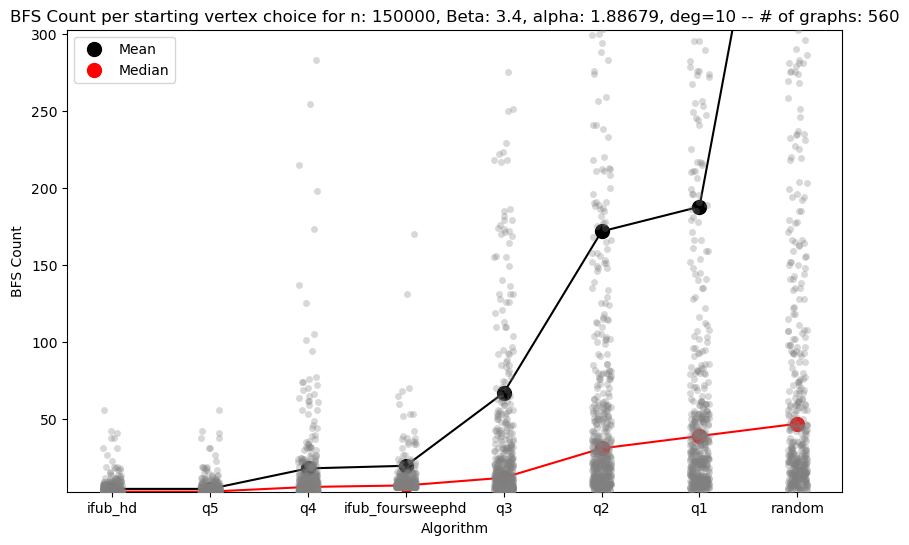

In [41]:
# Filter dimaeter data to contain only the subset we are intersted in
data = df_diameter[df_diameter["graph"].isin(df["graph"])]

# Ensure 'algo' is a categorical variable and sort by median bfs_count
algo_order = data.groupby("algo")["bfs_count"].median().sort_values().index
data["algo"] = pd.Categorical(data["algo"], categories=algo_order, ordered=True)

plt.figure(figsize=(10, 6))

# Plot all data points faintly
sns.stripplot(data=data, x="algo", y="bfs_count", color="gray", alpha=0.3, jitter=True)

# Compute mean and median for each algorithm (now ordered)
means = data.groupby("algo")["bfs_count"].mean().loc[algo_order]
medians = data.groupby("algo")["bfs_count"].median().loc[algo_order]

# Plot mean (black) and median (red)
plt.scatter(means.index, means.values, color="black", s=100, label="Mean")
plt.scatter(medians.index, medians.values, color="red", s=100, label="Median")

# Connect means (black line) and medians (red line) across x-values
plt.plot(means.index, means.values, color="black", linestyle="-", linewidth=1.5)
plt.plot(medians.index, medians.values, color="red", linestyle="-", linewidth=1.5)

# Resize y-axis to ignore extreme outliers
plt.ylim(data["bfs_count"].quantile(0.05), data["bfs_count"].quantile(0.93))  

# Labels and title
plt.xlabel("Algorithm")
plt.ylabel("BFS Count")
plt.title(f"BFS Count per starting vertex choice for n: {P_n}, Beta: {P_ple}, alpha: {P_alp}, deg={P_deg} -- # of graphs: {N_graphs}")
plt.legend()
plt.show()

### 6.2 BFS tree growth

In [42]:
print(f"diff N   values {df_girgs['n'].unique()}")
print(f"diff deg values {df_girgs['deg'].unique()}")
print(f"diff ple values {df_girgs['ple'].unique()}")
print(f"diff T   values {df_girgs['T'].unique()}")
print(f"diff alp values {df_girgs['alpha'].unique()}")
############################################################

df = df_girgs.copy()

P_n = 150000
P_deg = 10
P_ple = 2.75
P_alp = 1.42857

# Filter dataset to work on later
df = df[df['n'] == P_n]
df = df[df['deg'] == P_deg]
df = df[df['ple'] == P_ple]
df = df[df['alpha'] == P_alp]
df = df[df['type'] == "girg"]

N_graphs = df["graph"].size

diff N   values [100000 150000  10000  15000  20000  25000  30000  35000  40000  45000
  50000   5000]
diff deg values [10 15]
diff ple values [2.1  2.25 2.4  2.55 2.75 3.01 3.1  3.4  4.   2.5  3.   3.35]
diff T   values [0.     0.4    0.53   0.76   0.7    0.88   0.9999]
diff alp values [    inf 2.5     1.88679 1.31579 1.42857 1.13636 1.0001 ]


In [43]:
df = df_girgs.copy()
P_n = 150000
df = df[df['n'] == P_n]
df = df[df['type'] == "girg"]
data = df_branching[df_branching["graph"].isin(df["graph"])]

merged_df = df_girgs.merge(df_branching, on="graph", how="inner")
merged_df = merged_df[merged_df["graph"].isin(df["graph"])]
merged_df = merged_df[merged_df["algo"] == "ifub_hd"]
merged_df.head()

,graph,n,deg,dim,ple,T,alpha,square,seed,ground,type,algo,levels
6048,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,2323,torus,girg,ifub_hd,"[1, 35274, 96914, 4612, 241, 22, 2]"
6051,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,1,2323,square,girg,ifub_hd,"[1, 21788, 102398, 10284, 690, 79, 11, 2]"
6054,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,252,torus,girg,ifub_hd,"[1, 35307, 96428, 5178, 291, 24, 1]"
6057,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,1,252,square,girg,ifub_hd,"[1, 20883, 105598, 9390, 494, 48, 6]"
6060,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,321,torus,girg,ifub_hd,"[1, 34863, 94349, 5796, 356, 39, 5]"


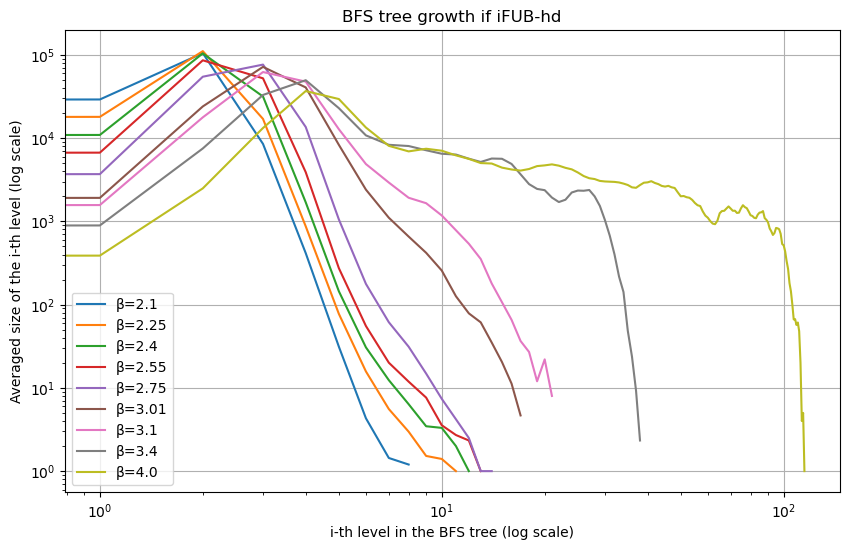

In [44]:
# Assuming `merged_df` is the DataFrame obtained after merging
# Step 1: Expand the levels column into multiple rows
expanded_rows = []
for _, row in merged_df.iterrows():
    for x, y in enumerate(row["levels"]):  # x = index, y = value
        expanded_rows.append({"ple": row["ple"], "x": x, "y": y})

expanded_df = pd.DataFrame(expanded_rows)

# Step 2: Group by `ple` and `x`, then compute the mean y-value
avg_df = expanded_df.groupby(["ple", "x"], as_index=False).mean()

# Step 3: Plot
plt.figure(figsize=(10, 6))
for ple_value, subset in avg_df.groupby("ple"):
    plt.plot(subset["x"], subset["y"], label=f"β={ple_value}")

plt.xscale("log")  # Log scale for x-axis
plt.yscale("log")  # Log scale for y-axis

plt.xlabel("i-th level in the BFS tree (log scale)")
plt.ylabel("Averaged size of the i-th level (log scale)")
plt.title("BFS tree growth if iFUB-hd")
plt.legend()
plt.grid()
plt.show()

### 6.1 individual BFS trees

In [45]:
dfdf=merged_df[merged_df["ple"] > 2.6]

g1 = "girgbig_n=150000_deg=10_dim=2_ple=2.75_T=0.0_seed=2323_square"
g2 = "girgbig_n=150000_deg=10_dim=2_ple=2.75_T=0.53_seed=2323"
dfdf.head()
diameter_data = df_diameter.copy()
diameter_data = diameter_data[diameter_data["algo"] == "q2"]

dfdf["diam"] = dfdf["graph"].map(diameter_data.set_index("graph")["diameter"]) / 2

dfdf.head()
dfdf = dfdf[dfdf["graph"] == g2]


/tmp/ipykernel_102018/969453758.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdf["diam"] = dfdf["graph"].map(diameter_data.set_index("graph")["diameter"]) / 2


/tmp/ipykernel_102018/3647753004.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="x", y="y", data=plot_df, estimator=np.mean, ci=None, color="royalblue")


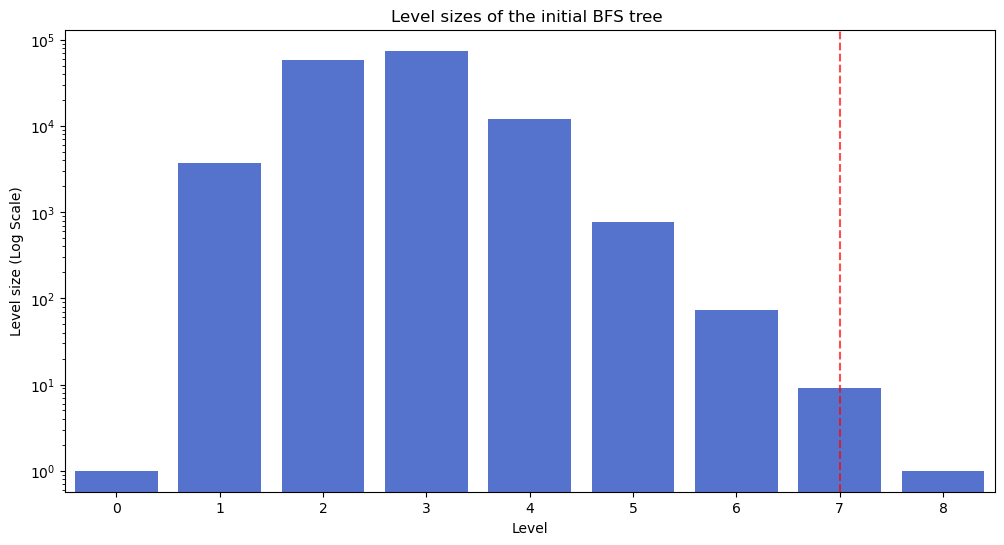

In [46]:
data = []
for _, row in dfdf.iterrows():
    levels = eval(row["levels"]) if isinstance(row["levels"], str) else row["levels"]  # Convert string to list if needed
    for x, y in enumerate(levels):
        data.append({"x": x, "y": y, "graph": row["graph"], "diam": row["diam"]})

# Convert to DataFrame
plot_df = pd.DataFrame(data)

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="x", y="y", data=plot_df, estimator=np.mean, ci=None, color="royalblue")

# Set y-axis to log scale
plt.yscale("log")

# Add vertical lines for each unique diameter
for diam in dfdf["diam"].unique():
    plt.axvline(x=diam, color="red", linestyle="--", alpha=0.7, linewidth=1.5)

# Labels and title
plt.xlabel("Level")
plt.ylabel("Level size (Log Scale)")
plt.title("Level sizes of the initial BFS tree ")

plt.show()

### 6.3: Spatial Distribution

In [51]:
# --- LOAD OLD DATA ---
df_spatial = pd.read_csv(f"../cluster_out/diameter_exact.csv", header=0)
df_geomgirgs = pd.read_csv(f"../cluster_out/girg_attributes.csv", header=0)

# Append 'ground' information to df_girgs
df_geomgirgs['ground'] = df_geomgirgs['graph'].apply(lambda x: 'square' if x.endswith('_square') else 'torus')

## flitering

df_geomgirgs = df_geomgirgs[df_geomgirgs['ple'] > 3]
df_geomgirgs = df_geomgirgs[df_geomgirgs['ground'] == "square"]
df_geomgirgs = df_geomgirgs[df_geomgirgs['alpha'] > 2]
df_spatial = df_spatial[df_spatial['algo'] == "ifub_foursweephd"]

merged_df = df_geomgirgs.merge(df_spatial, on="graph", how="inner")
merged_df.head()

,graph,n,deg,dim,ple,T,alpha,square,seed,ground,algo,diameter,bfs_count,chosenvtx,weightp,time_diameter_exact,sx,sy
0,girg_n=50000_deg=10_dim=2_ple=25.0_T=0.0_seed=...,50000,10,2,25.0,0.0,inf,1,1001,square,ifub_foursweephd,210,249,13781,0.491638,44733.5,0.528716,0.449760
1,girg_n=50000_deg=10_dim=2_ple=25.0_T=0.0_seed=...,50000,10,2,25.0,0.0,inf,1,14,square,ifub_foursweephd,217,8,36964,0.764139,2830.0,0.502504,0.491420
2,girg_n=50000_deg=10_dim=2_ple=25.0_T=0.0_seed=...,50000,10,2,25.0,0.0,inf,1,237,square,ifub_foursweephd,211,88,2525,0.994918,39060.2,0.522428,0.519438
3,girg_n=50000_deg=10_dim=2_ple=25.0_T=0.0_seed=...,50000,10,2,25.0,0.0,inf,1,2,square,ifub_foursweephd,209,836,5859,0.887962,321655.0,0.581930,0.566476
4,girg_n=50000_deg=10_dim=2_ple=25.0_T=0.0_seed=...,50000,10,2,25.0,0.0,inf,1,321,square,ifub_foursweephd,211,85,7065,0.654760,15687.1,0.499060,0.495364


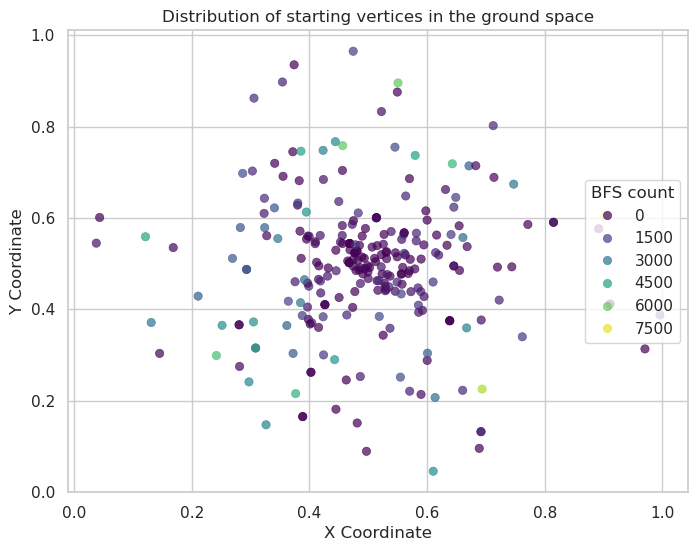

In [52]:
df = merged_df 
sns.set(style="whitegrid")

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="sx", y="sy", hue="bfs_count", palette="viridis", alpha=0.7, edgecolor=None)

# Titles and labels
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Distribution of starting vertices in the ground space")

plt.legend(title="BFS count", loc="right")
plt.show()

### 6.4 Eccentricity distribution per graph

In [53]:
print(f"diff N   values {df_girgs['n'].unique()}")
print(f"diff deg values {df_girgs['deg'].unique()}")
print(f"diff ple values {df_girgs['ple'].unique()}")
print(f"diff T   values {df_girgs['T'].unique()}")
print(f"diff alp values {df_girgs['alpha'].unique()}")
############################################################

df = df_girgs.copy()

P_n = 150000
P_deg = 10
P_ple = 2.75
P_alp = 1.42857

# Filter dataset to work on later
df = df[df['n'] == P_n]
df = df[df['deg'] == P_deg]
df = df[df['ple'] < 3]
#df = df[df['alpha'] == P_alp]
df = df[df['type'] == "girg"]

N_graphs = df["graph"].size

diff N   values [100000 150000  10000  15000  20000  25000  30000  35000  40000  45000
  50000   5000]
diff deg values [10 15]
diff ple values [2.1  2.25 2.4  2.55 2.75 3.01 3.1  3.4  4.   2.5  3.   3.35]
diff T   values [0.     0.4    0.53   0.76   0.7    0.88   0.9999]
diff alp values [    inf 2.5     1.88679 1.31579 1.42857 1.13636 1.0001 ]


In [54]:

merged_df = df.merge(df_ecc, on="graph", how="inner")
#
# merged_df = merged_df[merged_df["graph"].isin(df["graph"])]
#merged_df = merged_df[merged_df["algo"] == "ifub_hd"]
diameter_data = df_diameter[df_diameter["algo"] == "ifub_hd"]
merged_df["diam"] = merged_df["graph"].map(diameter_data.set_index("graph")["diameter"])
merged_df["start_ecc"] = merged_df["graph"].map(diameter_data.set_index("graph")["startvtx_ecc"])


merged_df.head()


,graph,n,deg,dim,ple,T,alpha,square,seed,ground,type,avg_ecc,median_ecc,sampleSize,ecc_to_degree,diam,start_ecc
0,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,2323,torus,girg,7.706,5,500,"[[7, 1], [7, 1], [7, 1], [7, 1], [7, 2], [7, 2...",12,6.0
1,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,1,2323,square,girg,8.67,5,500,"[[8, 1], [8, 1], [8, 1], [8, 1], [8, 1], [8, 1...",14,7.0
2,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,252,torus,girg,6.976,5,500,"[[6, 6], [6, 6], [6, 8], [6, 13], [6, 14], [6,...",11,6.0
3,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,1,252,square,girg,7.398,5,500,"[[6, 1807], [7, 1], [7, 1], [7, 1], [7, 1], [7...",12,6.0
4,girgbig_n=150000_deg=10_dim=2_ple=2.1_T=0.0_se...,150000,10,2,2.1,0.0,inf,0,321,torus,girg,7.762,4,500,"[[7, 1], [7, 1], [7, 1], [7, 1], [7, 1], [7, 1...",12,6.0


In [57]:
gg1 = "girgbig_n=150000_deg=10_dim=2_ple=2.75_T=0.53_seed=2323"

/tmp/ipykernel_102018/2531441002.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.axvline(x=int(selected_graph["diam"]), color="red", linestyle="--", alpha=0.7, linewidth=1.5)


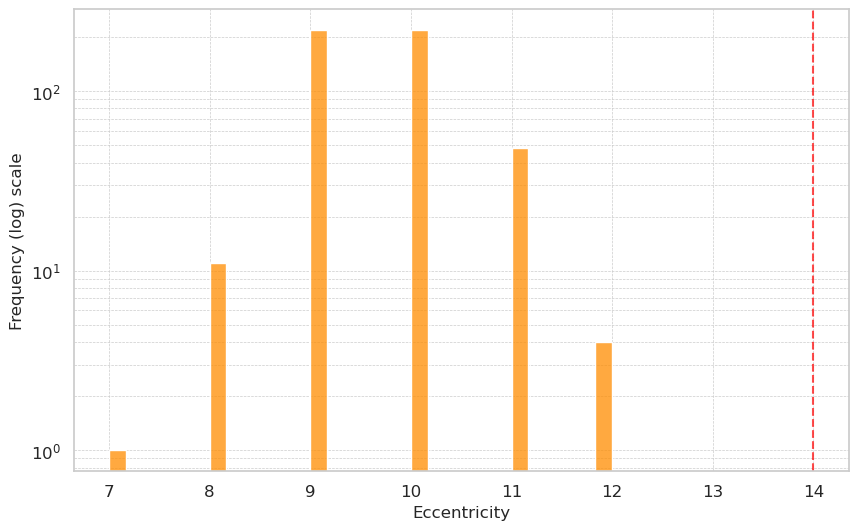

In [58]:
selected_graph = df[df["graph"] == gg1]
selected_expanded = selected_graph.explode("ecc_to_degree")
selected_expanded["eccentricity"] = selected_expanded["ecc_to_degree"].apply(lambda x: x[0])  # Extract eccentricity

plt.figure(figsize=(10, 6))
sns.histplot(selected_expanded["eccentricity"], bins=30, kde=False, color="darkorange")

plt.axvline(x=int(selected_graph["diam"]), color="red", linestyle="--", alpha=0.7, linewidth=1.5)

plt.xlabel("Eccentricity")
plt.ylabel("Frequency (log) scale")
plt.yscale("log")  # If necessary
#plt.title(f"Eccentricity Distribution for one graph")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



### 6.5 Typical diameters per regimes and parameter changes 

In [59]:
print(f"diff N   values {df_girgs['n'].unique()}")
print(f"diff deg values {df_girgs['deg'].unique()}")
print(f"diff ple values {df_girgs['ple'].unique()}")
print(f"diff T   values {df_girgs['T'].unique()}")
print(f"diff alp values {df_girgs['alpha'].unique()}")
############################################################

df = df_girgs.copy()

P_n = 150000
P_deg = 10
P_ple = 2.1
P_alp = 1.42857

# Filter dataset to work on later
df = df[df['n'] < 70000]
df = df[(df['ple'] == 2.4) | (df['ple'] == 3.5)]
df = df[df['deg'] == 10]
df = df[df['type'] == "girg"]

N_graphs = df["graph"].size
print(N_graphs)

diff N   values [100000 150000  10000  15000  20000  25000  30000  35000  40000  45000
  50000   5000]
diff deg values [10 15]
diff ple values [2.1  2.25 2.4  2.55 2.75 3.01 3.1  3.4  4.   2.5  3.   3.35]
diff T   values [0.     0.4    0.53   0.76   0.7    0.88   0.9999]
diff alp values [    inf 2.5     1.88679 1.31579 1.42857 1.13636 1.0001 ]
1120


In [60]:
data = df_diameter[df_diameter["graph"].isin(df["graph"])]
data = data[data["algo"] == "ifub_hd"]
merged_df = df.merge(data, on="graph", how="inner")
merged_df.head()

,graph,n,deg,dim,ple,T,alpha,square,seed,ground,type,algo,diameter,bfs_count,startvtx_degree,startvtx_ecc,time_diameter_exact
0,girg_n=10000_deg=10_dim=2_ple=2.4_T=0.0_seed=2323,10000,10,2,2.4,0.0,inf,0,2323,torus,girg,ifub_hd,13,5,1814,7.0,1.426230
1,girg_n=10000_deg=10_dim=2_ple=2.4_T=0.0_seed=2...,10000,10,2,2.4,0.0,inf,1,2323,square,girg,ifub_hd,14,3,1135,8.0,0.900702
2,girg_n=10000_deg=10_dim=2_ple=2.4_T=0.0_seed=252,10000,10,2,2.4,0.0,inf,0,252,torus,girg,ifub_hd,11,4,1799,6.0,1.115560
3,girg_n=10000_deg=10_dim=2_ple=2.4_T=0.0_seed=2...,10000,10,2,2.4,0.0,inf,1,252,square,girg,ifub_hd,12,2,1066,6.0,1.152470
4,girg_n=10000_deg=10_dim=2_ple=2.4_T=0.0_seed=321,10000,10,2,2.4,0.0,inf,0,321,torus,girg,ifub_hd,14,2,1813,7.0,0.660692


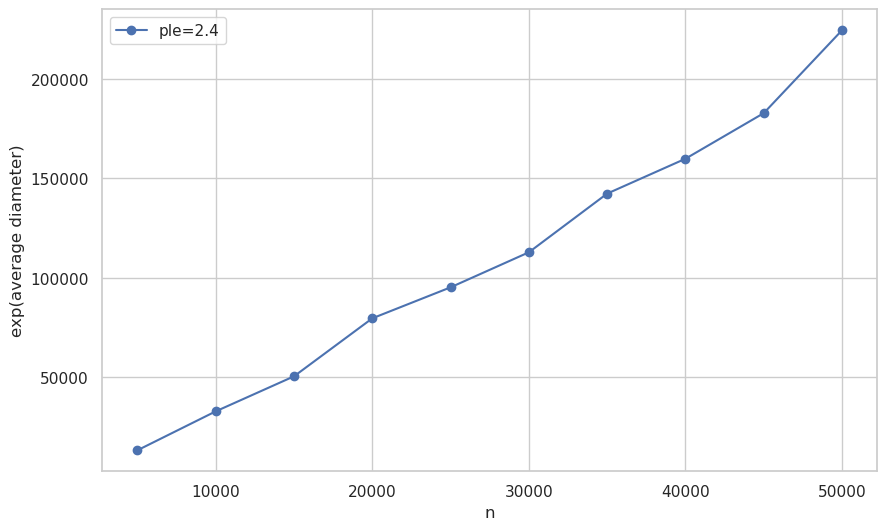

In [65]:
grouped = merged_df.groupby(['ple', 'n'])['diameter'].mean().reset_index()
grouped['exp_diameter'] = np.exp(grouped['diameter'])

plt.figure(figsize=(10, 6))
for ple_value, subset in grouped.groupby('ple'):
    plt.plot(subset['n'], subset['exp_diameter'], marker='o', linestyle='-', label=f'ple={ple_value}')

plt.xlabel("n")
plt.ylabel("exp(average diameter)")

plt.legend()
plt.grid(True)
plt.show()

In [62]:
grouped.head()

,ple,n,diameter,exp_diameter
0,2.4,5000,9.500000,13359.726830
1,2.4,10000,10.401786,32918.356000
2,2.4,15000,10.830357,50531.750621
3,2.4,20000,11.285714,79675.250692
4,2.4,25000,11.464286,95252.421409


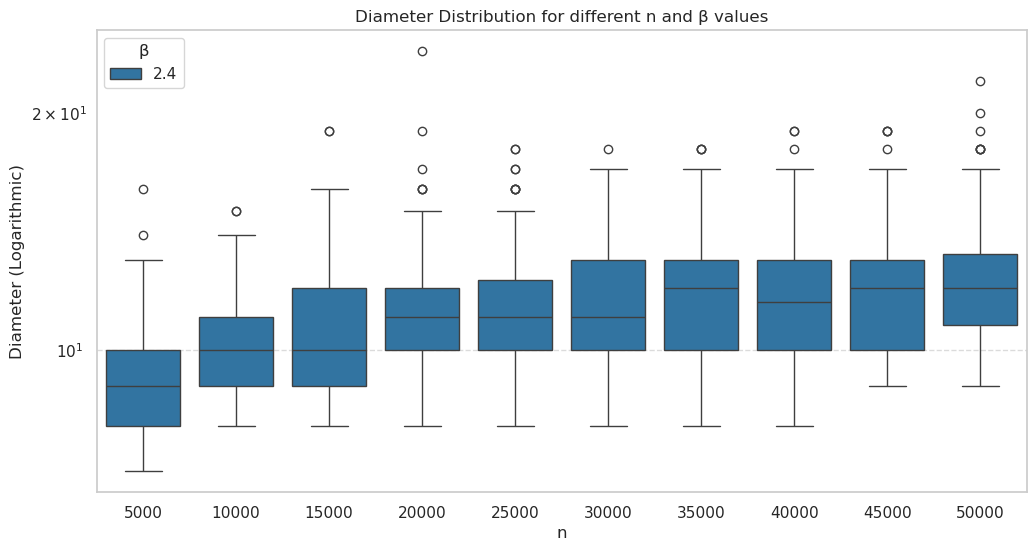

In [66]:
avg_diameter_long = merged_df.groupby(["n", "ple"])["diameter"].mean().reset_index()

# Create a boxplot to visualize the distribution of diameters per (n, ple) pair
plt.figure(figsize=(12, 6))
sns.boxplot(x="n", y="diameter", hue="ple", data=merged_df, palette="tab10")

# Labels and title
plt.xlabel("n")
plt.ylabel("Diameter (Logarithmic)")
plt.title("Diameter Distribution for different n and β values")
plt.legend(title="β")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.yscale("log")

# Show the plot
plt.show()